<a href="https://colab.research.google.com/github/sulaimanbehzad/Classifying-Images/blob/main/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifiers
The purpose of this project is to train two classifiers:
1. Captions classifier
2. Image classifier

In [30]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import utils
from keras.preprocessing import image
from keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
from keras.utils import np_utils
from keras import regularizers

## Part 2: Image Classifier

setting-up the parameters for image loader

In [31]:
img_width, img_height = 224, 224
path_train_images = r'/content/drive/MyDrive/dataset/train/images'   
path_test_images =  r'/content/drive/MyDrive/dataset/test/images'
path_dataset = r'/content/drive/MyDrive/dataset'
nb_train_samples = 532
nb_validation_samples = 380
epochs = 50
batch_size = 32

im_generator was repurposed to apply some mandatory disnormalities in images to make up for the small database, but it had a bad imapct on training

In [56]:
# im_generator = ImageDataGenerator(
# 	rotation_range=30,
# 	zoom_range=0.15,
# 	width_shift_range=0.2,
# 	height_shift_range=0.2,
# 	shear_range=0.15,
# 	horizontal_flip=True,
# 	fill_mode="nearest")
im_generator = ImageDataGenerator(
    # featurewise_center=True, samplewise_center=True,
    # rescale = 1/255.,
    fill_mode="nearest"
)

In [57]:
train_df = im_generator.flow_from_directory(
  path_train_images,
  # validation_split=0.2,
  class_mode="categorical",
  shuffle=False,
  # seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size,
  )



Found 532 images belonging to 19 classes.


In [58]:
val_df = im_generator.flow_from_directory(
  path_test_images,
  # validation_split=0.2,
  class_mode="categorical",
  shuffle=False,
  # seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size,
  )

Found 380 images belonging to 19 classes.


In [59]:
tags = train_df.labels
print(f'tags are: {tags} \n and length of tags is: {len(tags)}')

tags are: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 1

In [60]:
# data_augmentation = keras.Sequential(
#   [
#     layers.experimental.preprocessing.RandomFlip("horizontal", 
#                                                  input_shape=(img_height, 
#                                                               img_width,
#                                                               3)),
#     layers.experimental.preprocessing.RandomRotation(0.1),
#     layers.experimental.preprocessing.RandomZoom(0.1),
#   ]
# )


For feature extraction purposes we set include_top to false, it's whethere to include the fully connected layer at top_of the network

In [61]:
model_resnet = ResNet50(weights='imagenet', include_top=False, 
                              input_shape=(img_width, img_height, 3))
model_resnet.trainable = False
model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [62]:
model_efficient = EfficientNetB0(weights='imagenet', include_top=False, 
                              input_shape=(img_width, img_height, 3))
model_efficient.trainable = False
model_efficient.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 224, 224, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 224, 224, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_3[0][0]            
_____________________________________________________________________________________

In [63]:
X_train_e = model_efficient.predict(train_df, batch_size=batch_size)
# X_train_r = model_resnet.predict(train_df, batch_size=batch_size)

In [64]:
X_test_e = model_efficient.predict(val_df, batch_size=batch_size)
# X_test_r = model_resnet.predict(val_df, batch_size=batch_size)

In [65]:
# X_train.to_csv(r'/content/drive/MyDrive/dataset/train/X_train.csv', index=False)
# X_test.to_csv(r'/content/drive/MyDrive/dataset/test/X_test.csv', index=False )

In [66]:
# X_train = pd.read_csv('/content/drive/MyDrive/dataset/train/X_train.csv')
# X_test = pd.read_csv('/content/drive/MyDrive/dataset/test/X_test.csv')
# X_test

In [67]:
# plt.figure(figsize=(15, 10))
# for im, lbl in train_df.take(1):
#   for i in range(4):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(im[i].numpy().astype("uint8"))
#     plt.title(tags[lbl[i]])
#     plt.axis("off")


In [68]:
# AUTOTUNE = tf.data.AUTOTUNE
# train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# validation_df = validation_df.cache().prefetch(buffer_size=AUTOTUNE)


In [69]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [70]:
# normalized_df = train_df.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_df))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))


In [71]:
y_train = utils.to_categorical(train_df.labels)
y_test = utils.to_categorical(val_df.labels)

In [72]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [95]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=1e-3, momentum=0.9, decay=1e-3 / 25)
reg_hyp = 0
model = Sequential([
  # data_augmentation,
  # layers.experimental.preprocessing.Rescaling(1./255),
  layers.Flatten(),
  BatchNormalization(),
  layers.Dense(512, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.6),
  BatchNormalization(),
  layers.Dense(256, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.5),
  BatchNormalization(),
  layers.Dense(128, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.5),
  BatchNormalization(),
  layers.Dense(64, activation='selu', kernel_regularizer=regularizers.L2(reg_hyp)),
  layers.Dropout(0.5),
  BatchNormalization(),
  layers.Dense(19, activation='softmax')
])
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [97]:
history = model.fit(
    X_train_e,
    y_train,
    epochs=25,
    shuffle=True,
    validation_data=(X_test_e, y_test),
    batch_size=128 
)


Epoch 1/25
5/5 [==============================] - 5s 1000ms/step - loss: 0.4110 - accuracy: 0.9455 - val_loss: 1.4210 - val_accuracy: 0.6395
Epoch 2/25
5/5 [==============================] - 5s 1s/step - loss: 0.4112 - accuracy: 0.9342 - val_loss: 1.4063 - val_accuracy: 0.6342
Epoch 3/25
5/5 [==============================] - 5s 995ms/step - loss: 0.3688 - accuracy: 0.9511 - val_loss: 1.4008 - val_accuracy: 0.6447
Epoch 4/25
5/5 [==============================] - 5s 1s/step - loss: 0.3839 - accuracy: 0.9248 - val_loss: 1.4130 - val_accuracy: 0.6526
Epoch 5/25
5/5 [==============================] - 5s 991ms/step - loss: 0.3300 - accuracy: 0.9436 - val_loss: 1.3937 - val_accuracy: 0.6421
Epoch 6/25
5/5 [==============================] - 5s 997ms/step - loss: 0.3268 - accuracy: 0.9511 - val_loss: 1.3867 - val_accuracy: 0.6421
Epoch 7/25
5/5 [==============================] - 5s 978ms/step - loss: 0.3304 - accuracy: 0.9417 - val_loss: 1.3797 - val_accuracy: 0.6553
Epoch 8/25
5/5 [=========

In [98]:
history2 = model.fit(X_train_e,
                     y_train,
                     epochs=50,
                     shuffle=True,
                     validation_data=(X_test_e, y_test),
                     batch_size=128, 
                     initial_epoch=history.epoch[-1])

Epoch 25/50
5/5 [==============================] - 5s 1s/step - loss: 0.1535 - accuracy: 0.9831 - val_loss: 1.4701 - val_accuracy: 0.6211
Epoch 26/50
5/5 [==============================] - 5s 1s/step - loss: 0.1357 - accuracy: 0.9831 - val_loss: 1.4545 - val_accuracy: 0.6421
Epoch 27/50
5/5 [==============================] - 6s 1s/step - loss: 0.1525 - accuracy: 0.9850 - val_loss: 1.4664 - val_accuracy: 0.6526
Epoch 28/50
5/5 [==============================] - 5s 996ms/step - loss: 0.1404 - accuracy: 0.9868 - val_loss: 1.4702 - val_accuracy: 0.6500
Epoch 29/50
5/5 [==============================] - 5s 984ms/step - loss: 0.1403 - accuracy: 0.9887 - val_loss: 1.4787 - val_accuracy: 0.6421
Epoch 30/50
5/5 [==============================] - 5s 974ms/step - loss: 0.1506 - accuracy: 0.9850 - val_loss: 1.4800 - val_accuracy: 0.6447
Epoch 31/50
5/5 [==============================] - 5s 992ms/step - loss: 0.1406 - accuracy: 0.9774 - val_loss: 1.4776 - val_accuracy: 0.6474
Epoch 32/50
5/5 [=====

In [99]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 62720)             0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 62720)             250880    
_________________________________________________________________
dense_53 (Dense)             (None, 512)               32113152  
_________________________________________________________________
dropout_44 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 512)               2048      
_________________________________________________________________
dense_54 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)              

In [100]:
score = model.evaluate(X_test_e, y_test, batch_size=batch_size, verbose=1)
print(f'Test loss:{score[0]}')
print(f'Test accuracy:{score[1]}')

12/12 [==============================] - 1s 60ms/step - loss: 1.5898 - accuracy: 0.6395
Test loss:1.5897858142852783
Test accuracy:0.6394736766815186


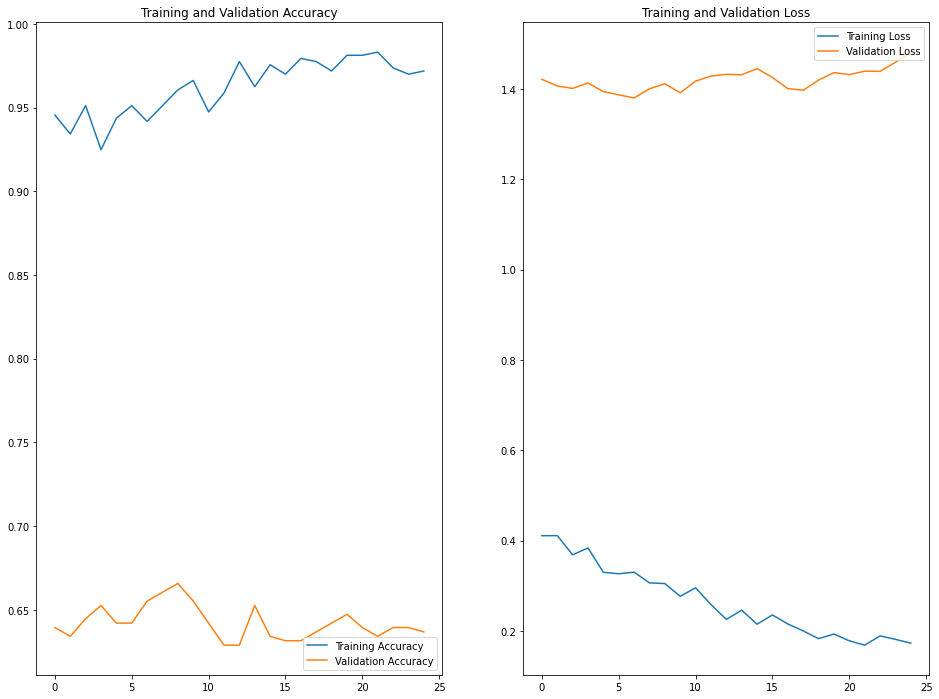

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss'] 

epochs_range = range(25)


plt.figure(figsize=(16, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


We tried the models below:  
1. VGG16
2. InceptionV3
3. InceptionResnetV2
4. ResNet50
5. Resnet50v2
6. EfficientNetB0 and B5   

the highest accuracy was obtained from EfficientNetB0 and ResNet50, while the first one is simpler in comparison its performance in this context proved to be better.



